# MS029 Epoching
06/27/2023

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re
import scipy

import warnings
warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/scripts/saez_python_pipeline/LFPAnalysis')

In [3]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [4]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/'
anat_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/recon_labels/'
neural_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/'
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

subj_id = 'MS029'
subj_format = ['edf']
subj_site = ['MSSM']


### Import Preprocessed Data

In [5]:
mne_data_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/wm_ref_ieeg.fif', preload=True)

photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

In [6]:
mne_data_reref

<Raw | wm_ref_ieeg.fif, 114 x 1611008 (3146.5 s), ~1.37 GB, data loaded>

In [7]:
photodiode_data

<Raw | photodiode.fif, 1 x 1611008 (3146.5 s), ~12.4 MB, data loaded>

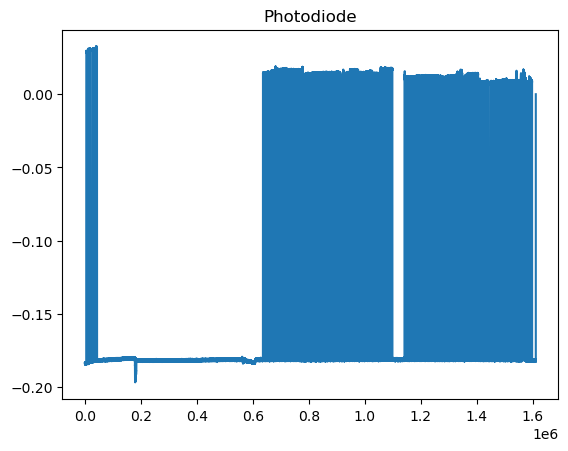

In [8]:
# Sanity check the photodiode
plt.plot(photodiode_data._data[0,])
plt.title("Photodiode")
plt.show()

### Load Anat Recon Info 


In [9]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,Manual Examination,Notes
0,LaCaS1,A13_L,-2.995627,39.955832,-20.977326,-3.651905,29.347904,-16.284472,Gray,Left MFC medial frontal cortex,Area s32,L Rectal Gyrus,L OrG,Left frontal pole 1 B,NaN,NaN
1,LaCaS10,A9/46d_L,-17.774106,64.755819,13.785092,-19.681925,52.011306,23.786070,White,Left SFG superior frontal gyrus,Unknown,L Middle Frontal Gyrus,L MFG,Left middle frontal gyrus 2 A,WM,NaN
2,LaCaS11,A9/46d_L,-18.972361,67.955818,17.381204,-20.959194,55.023796,28.128578,Gray,Left SFG superior frontal gyrus,Unknown,L Superior Frontal Gyrus,L MFG,Left middle frontal gyrus 2 A,NaN,NaN
3,LaCaS12,A9/46d_L,-20.570035,70.755816,20.178181,-22.702371,57.682280,31.549648,Gray,Left SFG superior frontal gyrus,Unknown,L Superior Frontal Gyrus,L MFG,Left middle frontal gyrus 2 A,OOB,NaN
4,LaCaS2,A32sg_L,-4.593300,42.755831,-16.981645,-5.454643,31.717963,-11.494004,Gray,Left ACgG anterior cingulate gyrus,Area s32,L Mid Orbital Gyrus,L CG,Left cingulate gyrus D,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,RmOlFLes5,A11l_R,24.164821,55.155824,-14.584237,24.934669,46.527631,-8.068891,White,Right Cerebral White Matter,Unknown,Unknown,R OrG,Unknown,WM,NaN
144,RmOlFLes6,Unknown,27.360168,54.755825,-10.988125,28.684556,45.895131,-4.288050,White,Right Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,WM,NaN
145,RmOlFLes7,Unknown,30.555515,54.755825,-6.992445,32.426271,45.690234,-0.110804,White,Right Cerebral White Matter,Unknown,Unknown,Unknown,Unknown,WM,NaN
146,RmOlFLes8,A9/46v_R,34.150280,54.355825,-2.996765,36.560806,45.178333,4.076871,Gray,Right Cerebral White Matter,Unknown,R Middle Frontal Gyrus,R MFG,Right anterior pars triangularis A,NaN,NaN


## Load behavior

In [10]:
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_pt_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
behav_df

,Round,Trial Num,TrialType,TrialOnset,ChoiceOnset,DecisionOnset,FeedbackOnset,RT,SafeBet,LowBet,...,weighted_low,p_g,p_s,util_rpe,util_tcpe,util_dcpe,util_tregret,util_dregret,util_trelief,util_drelief
0,1,8.0,mix,1506.387005,1506.389869,1509.934175,1509.941900,3.544306,0.0,-0.50,...,-0.301535,0.535623,0.464377,0.000000,-0.498850,-0.498850,-0.498850,-0.498850,0.000000,0.000000
1,2,101.0,loss,1516.756733,1516.765760,1521.528585,1523.544767,4.762825,-0.2,-0.34,...,-0.301419,0.554238,0.445762,0.000000,-0.301419,0.301099,-0.301419,0.301099,0.000000,0.000000
2,3,3.0,mix,1529.063686,1529.064585,1530.309289,1532.322965,1.244704,0.0,-0.30,...,-0.301381,0.535667,0.464333,-0.498941,-0.800322,-0.301381,-0.800322,-0.301381,0.000000,0.000000
3,4,70.0,gain,1541.833785,1541.839987,1544.449715,1544.458453,2.609728,0.3,0.00,...,0.000000,0.410796,0.589204,0.000000,0.998797,0.998797,0.000000,0.000000,0.998797,0.998797
4,5,102.0,loss,1551.051014,1551.051899,1553.928036,1555.944557,2.876137,-0.2,-0.36,...,-0.301436,0.554235,0.445765,0.301436,0.000000,0.602519,0.000000,0.000000,0.301436,0.602519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,108.0,loss,3281.226519,3281.227350,3283.662065,3285.678922,2.434714,-0.2,-0.72,...,-0.301645,0.554198,0.445802,0.301645,0.000000,0.602519,0.000000,0.000000,0.301645,0.602519
146,147,45.0,mix,3290.682584,3290.692911,3292.158064,3294.174198,1.465153,0.0,-1.10,...,-0.301773,0.535812,0.464188,-0.500139,-0.801912,-0.301773,-0.801912,-0.301773,0.000000,0.000000
147,148,38.0,mix,3307.483560,3307.484403,3315.446128,0.000000,0.000000,0.0,-0.50,...,-0.301535,0.535784,0.464216,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
148,149,6.0,mix,3317.784051,3317.791188,3319.076639,3319.084715,1.285451,0.0,-0.30,...,-0.301381,0.535733,0.464267,0.000000,0.301381,0.301381,0.000000,0.000000,0.301381,0.301381


In [11]:
beh_ts = behav_df['TrialOnset']

## Photodiode alignment

In [12]:
# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            photodiode_data, 
                                            smoothSize=11, windSize=15, height=0.5)

10 blocks
..........

found matches for 120 of 163 pulses
8 blocks
........

found matches for 140 of 163 pulses


## Make epochs

In [13]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}


In [14]:

# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0],
       'DecisionOnset': [0, 3.0]}

In [15]:
epochs_all_evs = {f'{x}': np.nan for x in evs}
epochs_all_baseline = {f'{x}': np.nan for x in evs}

In [16]:
for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/wm_ref_ieeg.fif', 
                 elec_path=anat_file, 
                 slope=slope, offset=offset,
                 behav_name=event, behav_times=behav_df[event].values, 
                 ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1.0, 
                 downsamp_factor=2, IED_args=IED_args)

    epochs_all_evs[event] = ev_epochs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 14704 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 17100 out of 17100 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 114 out of 114 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 2040 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 16970 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 17100 out of 17100 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend w

In [17]:
epochs_all_evs

{'TrialOnset': <Epochs |  150 events (all good), -2 - 0.996094 sec, baseline off, ~100.4 MB, data loaded, with metadata,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1 - 3.99609 sec, baseline off, ~167.2 MB, data loaded, with metadata,
  'DecisionOnset': 150>}

### Add metadata to epochs

In [18]:
for event in evs.keys():

    # Let's add our behavioral events to the metadata. Substitute this with the particulars for your behavioral dataframe. 

    event_metadata = epochs_all_evs[event].metadata.copy()
    
    #independent vars
    event_metadata['safe'] = behav_df['SafeBet'].tolist()
    event_metadata['low'] = behav_df['LowBet'].tolist()
    event_metadata['high'] = behav_df['HighBet'].tolist()
    event_metadata['profit'] = behav_df['Profit'].tolist()
    event_metadata['outcome'] = behav_df['Outcome'].tolist()
    #model-free vars
    event_metadata['g_ev'] = behav_df['GambleEV'].tolist()
    event_metadata['cr'] = behav_df['CR'].tolist()
    event_metadata['c_ev'] = behav_df['choiceEV'].tolist()
    event_metadata['rpe'] = behav_df['RPE'].tolist()
    event_metadata['tcpe'] = behav_df['totalCPE'].tolist()
    event_metadata['dcpe'] = behav_df['decisionCPE'].tolist()
    event_metadata['tregret'] = behav_df['totalRegret'].tolist()
    event_metadata['dregret'] = behav_df['decisionRegret'].tolist()
    event_metadata['trelief'] = behav_df['totalRelief'].tolist()
    event_metadata['drelief'] = behav_df['decisionRelief'].tolist()
    event_metadata['util_g'] = behav_df['util_g'].tolist()
    event_metadata['util_s'] = behav_df['util_s'].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

In [19]:
epochs_all_evs[event].metadata

,lmolf3,lmolf12,lacas7,lacas8,lacas9,lmcms9,lmcms10,rmcms9,rmcms10,lais11,...,c_ev,rpe,tcpe,dcpe,tregret,dregret,trelief,drelief,util_g,util_s
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,-0.10,-0.10,-0.10,-0.10,0.00,0.0,0.197315,0.000000
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.17,-0.17,-0.34,-0.14,-0.34,-0.14,0.00,0.0,-0.301419,-0.602519
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.09,-0.21,-0.42,-0.30,-0.42,-0.30,0.00,0.0,0.197560,0.000000
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,-1.20,-1.20,0.00,0.00,0.30,0.3,0.500203,0.998797
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.18,0.18,0.00,0.20,0.00,0.00,0.36,0.2,-0.301436,-0.602519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.36,0.36,0.00,0.20,0.00,0.00,0.72,0.2,-0.301645,-0.602519
146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.11,-1.21,-2.42,-1.10,-2.42,-1.10,0.00,0.0,0.198366,0.000000
147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.198209,0.000000
148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,-0.25,-0.25,0.00,0.00,0.30,0.3,0.197926,0.000000


### Save epoched data

In [20]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/epoch_{event}.fif', overwrite=True)